# Модель для прогнозирования количества заказов такси на следующий час


**Описание:**  
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Задача:** Разработать модель для прогнозирования количества заказов такси на следующий час   

**Метрика:** RMSE на тестовой выборке должно быть не больше 48

**План действий:** 
- Загрузите данные и выполните их ресемплирование по одному часу.
- Проанализировать данные.
- Сделайте тестовую выборку размером 10% от исходных данных.
- Обучите разные модели с различными гиперпараметрами. 
- Проверьте данные на тестовой выборке и сделайте выводы.  
    
**Целевой признак:** `Количество заказов` находится в столбце - 'num_orders'.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn. linear_model import Ridge
from sklearn. linear_model import RidgeCV
from sklearn. model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
import warnings 
warnings.filterwarnings('ignore')

---

**Загружаем датасет и сразу переводим столбец с датами и временем в формат datetime64 и указаываем его как индекс.**

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
df.shape

(26496, 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Делаем сортировку и ресемплирование по 1 часу.**

In [5]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [6]:
df.shape

(4416, 1)

## Анализ

**Проверяем что данные расположены  в хронологическом порядке** 

In [7]:
df.index.is_monotonic

True

**Проверим временные границы датафрейма. Данные у нас представлены за 6 месяцев 2018г.**

In [8]:
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


**Посмотрим как выглядят графики данных: изначальный, тренад , сезонности и шума.**

In [9]:
decomposed = seasonal_decompose(df)

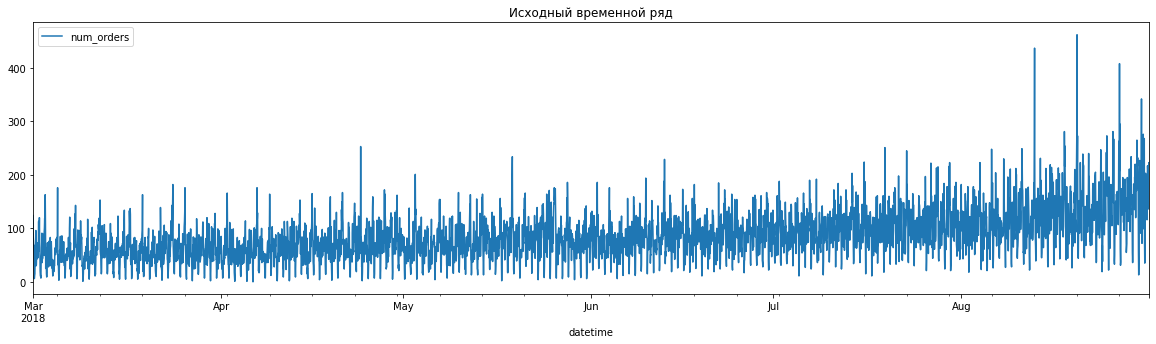

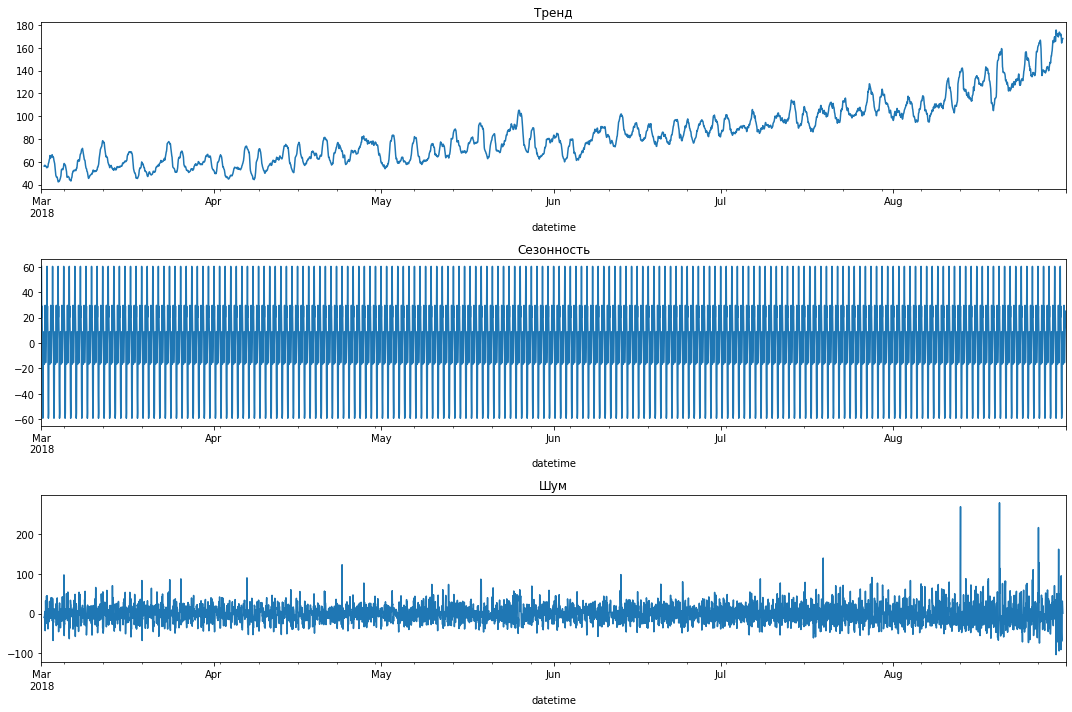

In [10]:
df.plot(figsize=(20,5), title = 'Исходный временной ряд')
plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Шум')
plt.tight_layout()

**Посмотрим график сезонности по ближе**

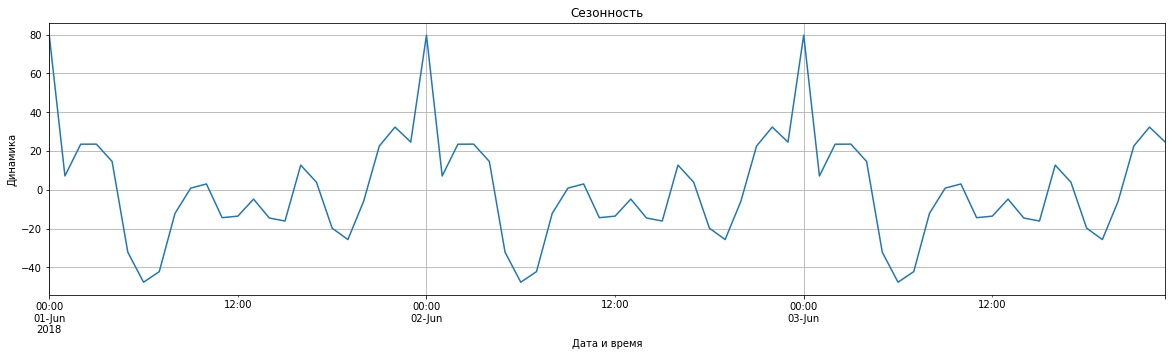

In [11]:
df_jun = df['2018-06-01':'2018-06-03']
decomposed_jun = seasonal_decompose(df_jun)
decomposed_jun.seasonal.plot(figsize=(20,5), title = 'Сезонность', grid = True)
plt.xlabel("Дата и время")
plt.ylabel("Динамика")
plt.show()

*Как видно по графику, пик нагрузки приходится на 00:00, минимум на 06:00.  
При этом направление движения графика меняется каждые 6 часов.  
Для того чтобы передать модели динамику внутри дня и при этом не сильно его сгладить при построении скользящей средней буду использовать окно размером в 3 часа.*

**Преобразуем наш времянной ряд в стационарный:**

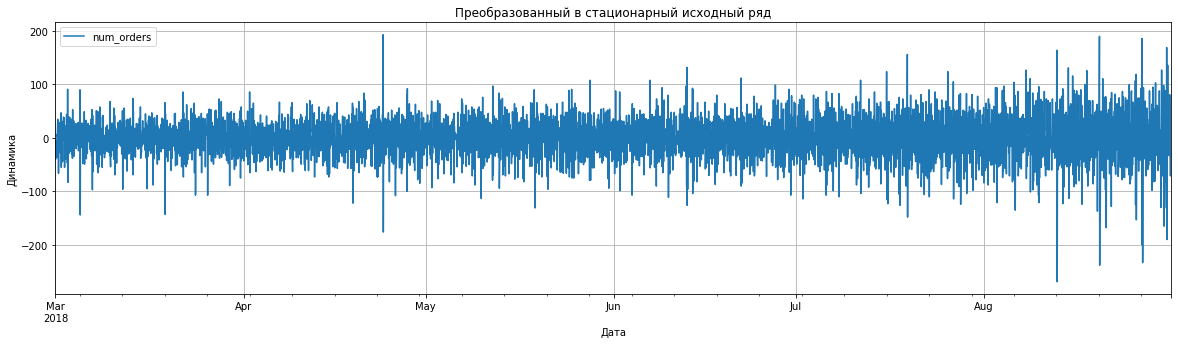

In [12]:
df_sh = df.shift()
df_sh = df - df_sh
df_sh.plot(figsize=(20,5), title = 'Преобразованный в стационарный исходный ряд', grid = True)
plt.xlabel("Дата")
plt.ylabel("Динамика")
plt.show()

**Посмотрим на автокорреляцию:**

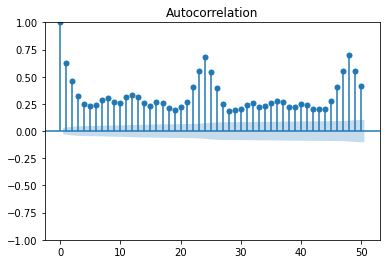

In [13]:
autocor = tsaplots.plot_acf(df, lags=50)
plt.show() 

По графику видно, что  лаг 24 и 48 сильнее коррелирует с исходным рядом, чем соседние лаги.
Такая автокорреляция позволяет предположить наличие (ежегодных) сезонных колебаний.
То, что корреляция постоянно положительная говорит о наличии тренда. 
Все это согласуется с тем, что мы узнали о данных, когда раскладывали их на компоненты.  

Синяя граница позволяет оценить статистическую значимость корреляции. Если столбец выходит за ее пределы, то автокорреляция достаточно сильна и ее можно использовать при построении модели. Таким образом для модели будет лучше всего использовтаь лаг в 24.

**Вывод:**  
- Данные представлены за период с 2018-03-01 00:00:00 по 2018-08-31 23:00:00
- Хронологический порядок соблюден.
- Временной ряд не является стационарным. 
- Имеет место ярков выраженный восходящий тренд с максимумом в районе 180 
- Сезонность: пик нагрузки приходится на 00:00, минимум на 06:00. Направление движения графика меняется каждые 6 часов.
- Шумы представлены на всем периоде наблюдений.
- Сильная автокорреляция, максимум достигается на лаге в 24 и 48.

---

## Обучение

### Создадим признаки для прогнозирования модели

**Создадим функцию которая создаст все необходимые дополнительные признаки:**
- Месяц: Так как данные представлены за март-август, вычленим отдельно месяцы, т.к. в летнее время люди больше летают и соответственно будут чаще пользоваться такси, тренд будет возрастать.
- День месяца: возможно есть зависимость от дня месяца, колебания по праздникам будут заметны.
- День недели: в рабочие дни люди летают чаще чем в выходные
- Сдвиг: буду использовать 24 т.к. корреляция на данном часе максимальная
- Скользящее среднее: буду использовать окно в 3 часа т.к. это позволит передать модели динамику внутри дня.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
make_features(df, 24, 3)

In [15]:
df

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,207.000000
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,186.666667
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.666667


### Подготовим данные к обучению

Так как данные у нас уже сортированы и расположены в хронологическом порядке, мы можем просто разделить данные на обучающую и тестовые выборки применив train_test_split с параметром shuffle=False, чтообы исключить перемешивание.
Согласно заданию, тестовая выборка должна составлять 10%.
После чего удалим NaN в трейне.

In [16]:
df.shape

(4416, 29)

In [17]:
train, val = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(val, shuffle=False, test_size=0.5)
train = train.dropna()

**Проверим чтобы время выборок не пересекалось:**

In [18]:
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


**Разделим данные на признаки**

In [19]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Линейная регрессия

In [20]:
model_reg = LinearRegression(fit_intercept=False, normalize = False)
model_reg.fit(features_train, target_train)
predict_reg = pd.Series(model_reg.predict(features_valid))
rmse_reg = mean_squared_error(target_valid, predict_reg)**0.5
print("LinearRegression: RMSE валидационной выборки:", rmse_reg)

LinearRegression: RMSE валидационной выборки: 33.95329036948003


In [21]:
predict_reg = predict_reg.to_frame().set_index(target_valid.index)

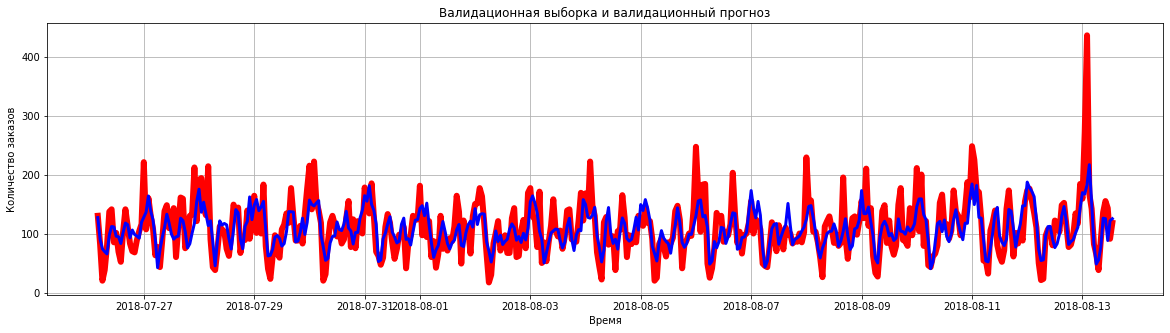

In [22]:
plt.figure(figsize=(20,5))
plt.plot(target_valid, color = "red", linewidth= 6)
plt.plot(predict_reg, color = "blue", linewidth= 3)
plt.title("Валидационная выборка и валидационный прогноз")
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.grid()
plt.show()

### RidgeCV

Подберем гиперпараметры:

In [23]:
cv = TimeSeriesSplit(n_splits=3, gap=2)
model = RidgeCV(alphas= arange (0, 1, 0.01), cv=cv, scoring='neg_mean_squared_error')
model.fit(features_train, target_train)
print(model.alpha_)

0.01


In [24]:
model_rcv = RidgeCV(cv=cv)
model_rcv.fit(features_train, target_train)
predict_rcv = pd.Series(model_rcv.predict(features_valid))
rmse_rcv = mean_squared_error(target_valid, predict_rcv)**0.5
print("RidgeCV: RMSE валидационной выборки:", rmse_rcv)

RidgeCV: RMSE валидационной выборки: 34.06757656047578


In [25]:
predict_rcv = predict_rcv.to_frame().set_index(target_valid.index)

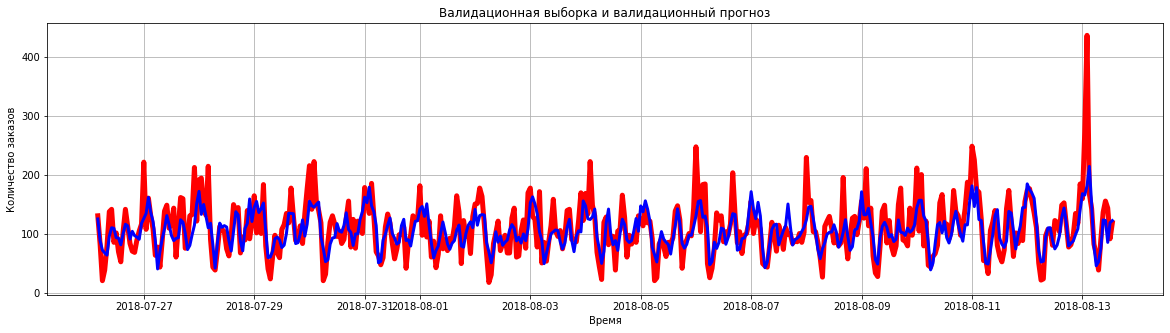

In [26]:
plt.figure(figsize=(20,5))
plt.plot(target_valid, color = "red", linewidth= 5)
plt.plot(predict_rcv, color = "blue", linewidth= 3)
plt.title("Валидационная выборка и валидационный прогноз")
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.grid()
plt.show()

###  Дерево Решений

Подбираем параметры:

In [27]:
best_rmse_tr = 48 
best_depth = 0
for depth in range(1, 21):
    model_tr = DecisionTreeRegressor(random_state=1234567, max_depth=depth)
    model_tr.fit(features_train, target_train)
    predict_tr = pd.Series(model_tr.predict(features_valid))
    rmse_tr = mean_squared_error(target_valid, predict_tr)**0.5
    if rmse_tr < best_rmse_tr:
            best_rmse_tr = rmse_tr
            best_depth = depth
print('Дерево Решений: RMSE валидационной выборки:', best_rmse_tr)
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth) 

Дерево Решений: RMSE валидационной выборки: 39.66056858699623
Количество ветвей наилучшей модели на валидационной выборке: 6


In [28]:
predict_tr = predict_tr.to_frame().set_index(target_valid.index)

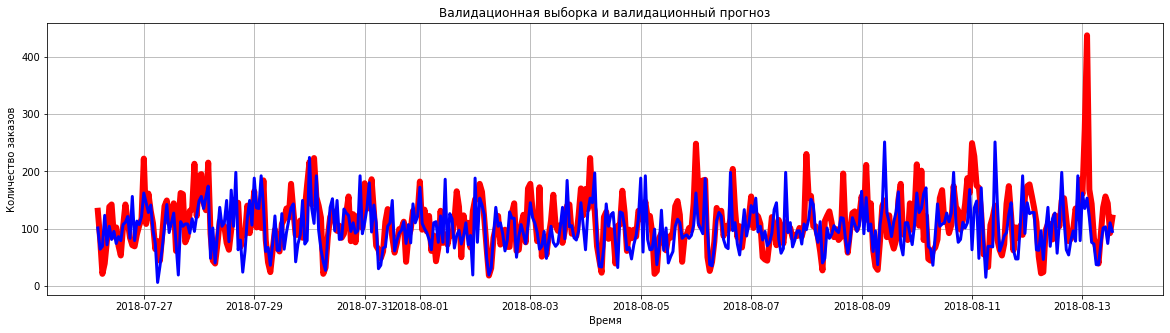

In [29]:
plt.figure(figsize=(20,5))
plt.plot(target_valid, color = "red", linewidth= 6)
plt.plot(predict_tr, color = "blue", linewidth= 3)
plt.title("Валидационная выборка и валидационный прогноз")
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.grid()
plt.show()

**Вывод:**
При проведении обучения, были использованы модели:
- LinearRegression: RMSE на валидационной выборке - 33,95
- RidgeCV: RMSE на валидационной выборке - 34,06
- Дерево Решений: RMSE на валидационной выборке - 39,66

Обозначенный заказчиком предел RMSE < 48 преодолели все модели, наилучшим образом с задачей справилась модель LinearRegression, ее будем проверять на тестовых данных.

## Тестирование

In [30]:
predict_reg_test = pd.Series(model_reg.predict(features_test))
rmse_reg_test = mean_squared_error(target_test, predict_reg_test)**0.5
print("LinearRegression: RMSE на тестовой выборки:", rmse_reg_test)

LinearRegression: RMSE на тестовой выборки: 45.31722175207799


In [31]:
predict_reg_test = predict_reg_test.to_frame().set_index(target_test.index)

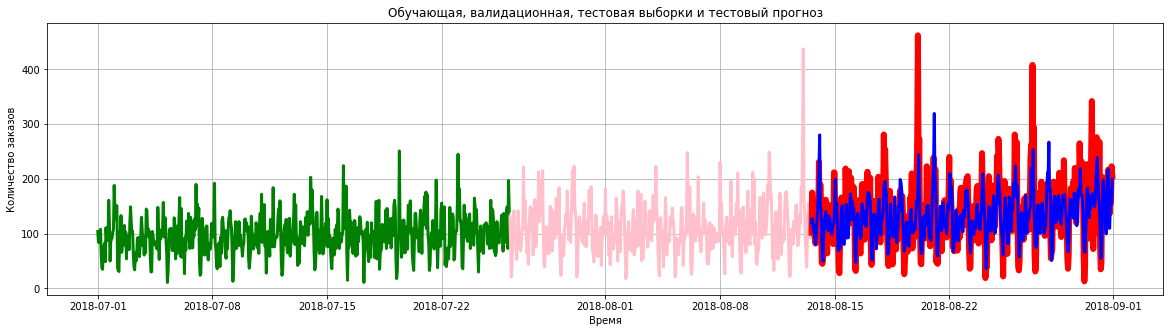

In [32]:
plt.figure(figsize=(20,5))
plt.plot(target_train['2018-07':], color = "green", linewidth= 3)
plt.plot(target_valid, color = "pink", linewidth= 3)
plt.plot(target_test, color = "red", linewidth= 6)
plt.plot(predict_reg_test, color = "blue", linewidth= 3)
plt.title("Обучающая, валидационная, тестовая выборки и тестовый прогноз")
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.grid()
plt.show()

**Проверим модель на адекватность, посредствам прогнозирования нового значение предыдущим значением ряда и медианной:**

In [33]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_valid.iloc[-1]
rmse_previous = mean_squared_error(target_test, pred_previous)**0.5
print("RMSE :", rmse_previous)

RMSE : 58.856486242815066


In [34]:
pred_median = np.ones(target_test.shape) * target_test.median() 
rmse_median = mean_squared_error(target_test, pred_median)**0.5
print("RMSE :", rmse_median)

RMSE : 58.7266464607412


**Вывод:**  

На тестовых данных модель LinearRegression показала RMSE - 45,31, наблюдается некоторое снижение качества.  
Обозначенный заказчиком уровень качества RMSE <48 - преодолён.  

Поверка на адекватность показала что обученная модель LinearRegression предсказывает результат намного лучше чем предсказание предыдущим значением ряда или медианной.

**ВЫВОД:**  

**Загрузка данных и анализ:**
- Данные представлены за период с 2018-03-01 00:00:00 по 2018-08-31 23:00:00
- Хронологический порядок соблюден.
- Временной ряд не является стационарным. 
- Имеет место ярков выраженный восходящий тренд с максимумом в районе 180 
- Сезонность: пик нагрузки приходится на 00:00, минимум на 06:00. Направление движения графика меняется каждые 6 часов.
- Шумы представлены на всем периоде наблюдений.
- Сильная автокорреляция, максимум достигается на лаге в 24 и 48.

**Подготовка к обучению:**
- Созданы дополнительные параметры для построения моделей: 
    - Календарные признаки:  месяц, день и день недели.
    - отстающие признаки: взят лаг 24 согласно показателю максимальной автокорреляции 
    - скользящее среднее: размер окна - 3.
- Данные разделены на train, valid и  test, в пропорции 80/10/10 соответственно.
- Удалены NaN в трейне после создания дополнительных признаков.

**Обучение:**
- LinearRegression: RMSE на валидационной выборке - 33,95
- RidgeCV: RMSE на валидационной выборке - 34,06
- DecisionTreeRegressor: RMSE на валидационной выборке - 39,66

Обозначенный заказчиком уровень качества RMSE < 48 преодолели все модели, наилучшим образом с задачей справилась модель LinearRegression.

**Тестирование:** 

**Проверка LinearRegression на тестовой выборке показала RMSE - 45,31. Обозначенный заказчиком уровень качества RMSE < 48 - достигнут.**

Проверка на адекватность показала, что качество целевой метрики RMSE: у медианы- 58,72, по предыдущему значению - 58,85.  
Таким образом можно утверждать что обученная модель LinearRegression предсказывает данный временной ряд гораздо качественнее.
